In [29]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


In [2]:
#Reading in all the data and doing some preliminary analysis
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')

train = pd.read_csv('Data/train_E6oV3lV.csv')
print("Training Set:"% train.columns, train.shape)
test = pd.read_csv('Data/test_tweets_anuFYb8.csv')
print("Test Set:"% test.columns, test.shape)

print('Train_Set -----')
print(train.isnull().sum())
print('Test_set -----')
print(test.isnull().sum())
train.head()

Training Set: (31962, 3)
Test Set: (17197, 2)
Train_Set -----
id       0
label    0
tweet    0
dtype: int64
Test_set -----
id       0
tweet    0
dtype: int64


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [3]:
train['label'].value_counts() #count number of  positive and negative  tweet

0    29720
1     2242
Name: label, dtype: int64

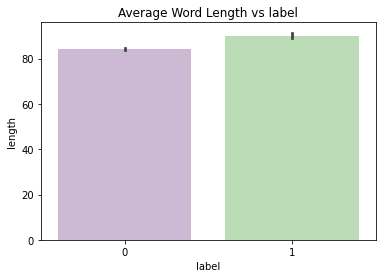

In [4]:
#Exploratory Data Analysis
train['length'] = train['tweet'].apply(len)
fig1 = sns.barplot('label','length',data = train,palette='PRGn')
plt.title('Average Word Length vs label')
plot = fig1.get_figure()
plot.savefig('Barplot.png')

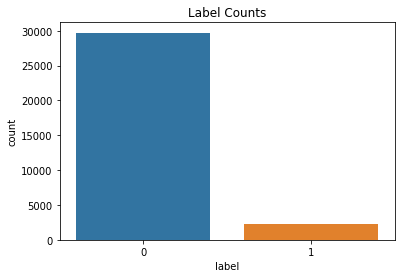

In [5]:
#bar graph to count positive negative label
fig2 = sns.countplot(x= 'label',data = train)
plt.title('Label Counts')
plot = fig2.get_figure()
plot.savefig('Count Plot.png')

In [6]:
#count of words disrtibution
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
train['length'].iplot(
    kind='hist',
    bins=100,
    xTitle='word count',
    linecolor='black',
    yTitle='count',
    title='Review Text Word Count Distribution')

In [7]:
import re
from sklearn.utils import resample

def  clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    return df
test_clean = clean_text(test, "tweet")
train_clean = clean_text(train, "tweet")

train_majority = train_clean[train_clean.label==0]
train_minority = train_clean[train_clean.label==1]
train_minority_upsampled = resample(train_minority, 
                                 replace=True,    
                                 n_samples=len(train_majority),   
                                 random_state=123)
train_upsampled = pd.concat([train_minority_upsampled, train_majority])
train_upsampled['label'].value_counts()

1    29720
0    29720
Name: label, dtype: int64

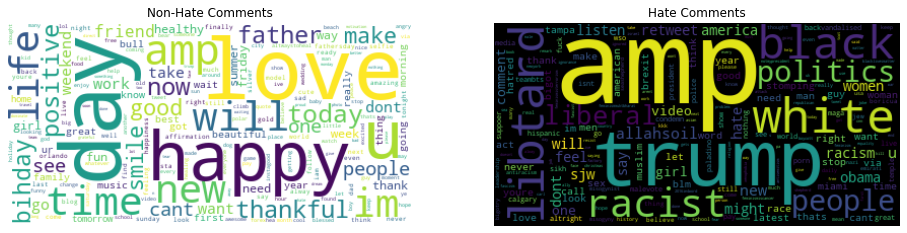

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2 , figsize=(16,8))
text_pos = " ".join(train_clean['tweet'][train.label == 0])
text_neg = " ".join(train_clean['tweet'][train.label == 1])
train_cloud_pos = WordCloud(collocations = False, background_color = 'white').generate(text_pos)
train_cloud_neg = WordCloud(collocations = False, background_color = 'black').generate(text_neg)
axs[0].imshow(train_cloud_pos, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Non-Hate Comments')
axs[1].imshow(train_cloud_neg, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Hate Comments')

plt.show()

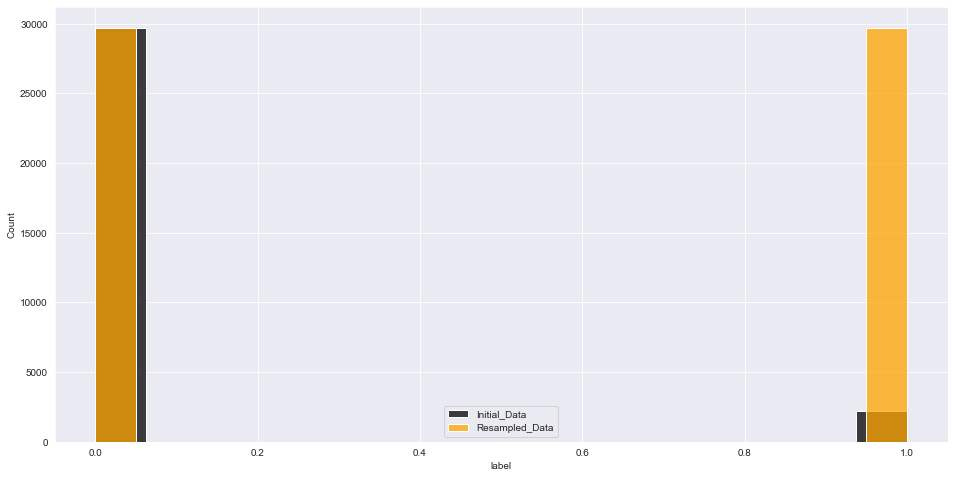

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
sns.set_style('darkgrid')
sns.histplot(data = train['label'], color='black', legend=True)
sns.histplot(data = train_upsampled['label'], color = 'orange', legend=True)
plt.legend(['Initial_Data', 'Resampled_Data'])
plt.show()

--------------After Upsampling the Minority Class---------------


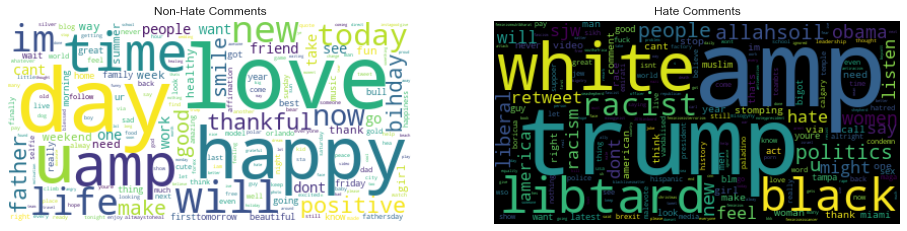

In [10]:
from wordcloud import WordCloud

print('--------------After Upsampling the Minority Class---------------')

fig, axs = plt.subplots(1,2 , figsize=(16,8))
text_pos = " ".join(train_upsampled['tweet'][train.label == 0])
text_neg = " ".join(train_upsampled['tweet'][train.label == 1])
train_cloud_pos = WordCloud(collocations = False, background_color = 'white').generate(text_pos)
train_cloud_neg = WordCloud(collocations = False, background_color = 'black').generate(text_neg)
axs[0].imshow(train_cloud_pos, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Non-Hate Comments')
axs[1].imshow(train_cloud_neg, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Hate Comments')

plt.show()

In [30]:
import xgboost as xgb
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score


pipeline_xgb = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf',  TfidfTransformer()),
    ('nb', xgb.XGBClassifier(use_label =False)),])

x_train, x_test, y_train, y_test = train_test_split(train_upsampled['tweet'],
                                                    train_upsampled['label'],random_state = 0)

model = pipeline_xgb.fit(x_train, y_train)
y_predict = model.predict(x_test)
print('--'* 20)
print('F1_Score: ',f1_score(y_test, y_predict))
print('Accuracy_Score: ', accuracy_score(y_test, y_predict))
print('--'*20)
print('---RepeatedKFOLD---')
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 2, random_state =1)
score2 = cross_val_score(pipeline_xgb, x_train, y_train, cv=cv, scoring='f1_micro', n_jobs=1)
score2 = np.mean(score2)
print('--'* 20)
print('RKFold_Score: ', score2)
print('--'* 20)

[23:52:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "use_label" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:52:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
----------------------------------------
F1_Score:  0.9159862338889263
Accuracy_Score:  0.9162180349932705
----------------------------------------
---RepeatedKFOLD---
[23:52:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Pa

In [19]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
count_vect = CountVectorizer(stop_words='english')
transformer = TfidfTransformer(norm='l2',sublinear_tf=True)

In [23]:
x_train_counts = count_vect.fit_transform(x_train)
x_train_tfidf = transformer.fit_transform(x_train_counts)
print(x_train_counts.shape)
print(x_train_tfidf.shape)

(44580, 34641)
(44580, 34641)


In [26]:
x_test_counts = count_vect.transform(x_test)
x_test_tfidf = transformer.transform(x_test_counts)


from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=500)
model.fit(x_train_tfidf,y_train)

RandomForestClassifier(n_estimators=500)

In [28]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import re

predictions = model.predict(x_test_tfidf)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test, predictions))

[[7275  215]
 [   0 7370]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      7490
           1       0.97      1.00      0.99      7370

    accuracy                           0.99     14860
   macro avg       0.99      0.99      0.99     14860
weighted avg       0.99      0.99      0.99     14860



In [31]:
#Logistic Regression Model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=42)
#Building Logistic Regression  Model
logreg.fit(x_train_tfidf,y_train)

predict_log = logreg.predict(x_test_tfidf)

print(confusion_matrix(y_test,predict_log))
print(classification_report(y_test, predict_log))

[[7210  280]
 [  72 7298]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      7490
           1       0.96      0.99      0.98      7370

    accuracy                           0.98     14860
   macro avg       0.98      0.98      0.98     14860
weighted avg       0.98      0.98      0.98     14860



In [32]:
#SVM Model
from sklearn import svm
lin_clf = svm.LinearSVC()
lin_clf.fit(x_train_tfidf,y_train)

predict_svm = lin_clf.predict(x_test_tfidf)

from sklearn.metrics import confusion_matrix,f1_score
print(confusion_matrix(y_test,predict_svm))
print(classification_report(y_test, predict_svm))

[[7332  158]
 [  21 7349]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      7490
           1       0.98      1.00      0.99      7370

    accuracy                           0.99     14860
   macro avg       0.99      0.99      0.99     14860
weighted avg       0.99      0.99      0.99     14860

